# Tutorial 1: Human dorsolateral prefrontal cortex (10x Visium)
This tutorial demonstrates the analysis of a human Dorsolateral Prefrontal Cortex (DLPFC) dataset from 10x Visium. The data from Maynard et al. includes manual annotations of the cortical layers and white matter (WM), which were identified using morphological features and gene markers.

Dataset could be downloaded from [SpatialLIDB](https://github.com/LieberInstitute/spatialLIBD)

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

from cadast import CadaST
from cadast.utils import clustering

from sklearn.metrics.cluster import adjusted_rand_score

In [ ]:
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (3, 3)
seed = 2025 
sc.settings.seed = seed

## Load the visium data and annotation files

In [3]:
dataset_path = "../dataset/DLPFC"  # Replace with the actual path to your dataset
section = "151673"
input_dir = os.path.join(dataset_path, section)
annotation = os.path.join(dataset_path, "annotation", section + "_truth.txt")
annotation = pd.read_csv(annotation, sep="\t", index_col=0, header=None)
adata = sc.read_visium(input_dir)
adata.var_names_make_unique()
adata.obs["truth"] = annotation

adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

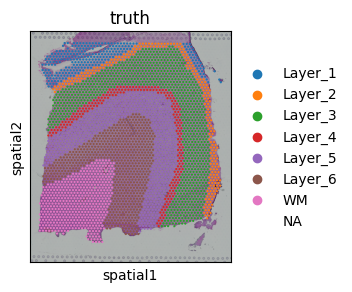

In [4]:
sc.pl.spatial(adata, color="truth")

## Preprocess the data

In [5]:
# Preprocess the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)

## Run CadaST
Including 3 steps:
1. Graph Construction 
2. Feature Selection
3. Iteratively predict and imputation

## Default parameters:
```beta=10, alpha=0.6, theta=0.2```

In [ ]:
n_top = 3000 # n_top SVG
n_jobs = 32 # parallel jobs 
model = CadaST(
    adata,
    n_top=n_top,
    n_jobs=n_jobs,
    seed=seed  
)
adata_fit = model.fit()
adata_fit 

Constructing KNN
Initializing neighbor correlation matrix 
Initialized model with beta: 10, alpha: 0.6, theta: 0.2
Filtering genes with top 3000 SVG features
Start CadaST model fitting


100%|██████████| 3000/3000 [00:06<00:00, 429.16it/s] 


AnnData object with n_obs × n_vars = 3639 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'truth'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'spatial', 'truth_colors', 'log1p'
    obsm: 'spatial'
    layers: 'labels'

## Cluster with mclust and spatial domain visualization

In [7]:
clustering(adata=adata_fit, n_clusters=7, dim_search=(6,12), refine=True, seed=seed)
obs_df = adata_fit.obs.dropna()
ARI = adjusted_rand_score(obs_df['domain'], obs_df['truth'])
print('Adjusted rand index = %.2f' %ARI)

Clustering using mclust


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



Adjusted rand index = 0.64


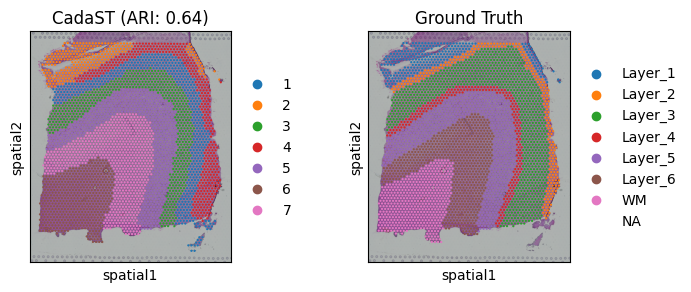

In [8]:
sc.pl.spatial(adata_fit, color=["domain", "truth"], title = [f"CadaST (ARI: {ARI:.2f})", "Ground Truth"])

## Plot the features' predicted states and the denoised expression

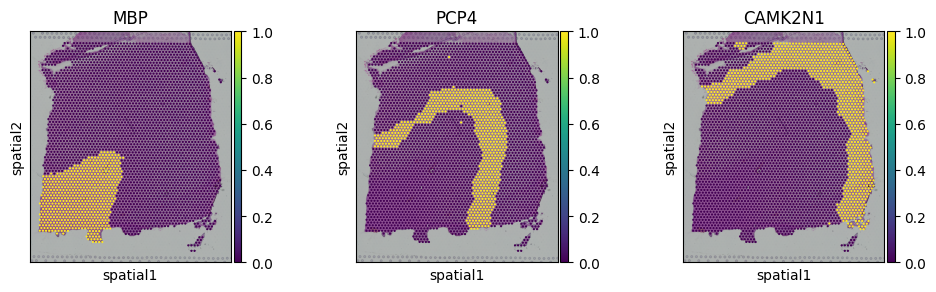

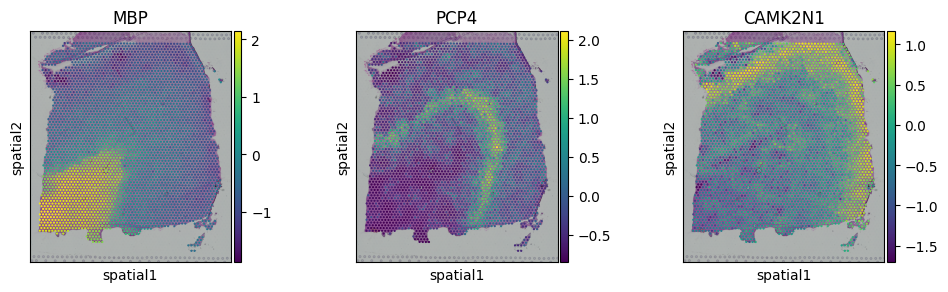

In [9]:
# Plot the features' predicted states and the denoised expression
sc.pl.spatial(adata_fit, color=["MBP", "PCP4", "CAMK2N1"], layer="labels")
sc.pl.spatial(adata_fit, color=["MBP", "PCP4", "CAMK2N1"])

---

## Robustness Analysis
Run with default parameters with different initialization random seed 

In [10]:
reps = 10
n_top = 3000 # n_top SVG
n_jobs = 32 # parallel jobs 
aris = []
for i in range(reps):
    seed = np.random.randint(0, 2**10)
    np.random.seed(seed)
    print(f"Run {i+1}/{reps}, seed={seed}")
    model = CadaST(
        adata,
        n_top=n_top,
        max_iter=2, # accelerate the test demo
        n_jobs=n_jobs,
        seed=seed  #fix the random seed
    )
    adata_fit = model.fit()
    clustering(adata_fit, n_clusters=7, dim_search=(6, 12), refine=True, seed=seed)
    obs_df = adata_fit.obs.dropna()
    ARI = adjusted_rand_score(obs_df['domain'], obs_df['truth'])
    aris.append(ARI)
    print('Adjusted rand index = %.2f' %ARI)

Run 1/10, seed=574
Constructing KNN
Initializing neighbor correlation matrix 
Initialized model with beta: 10, alpha: 0.6, theta: 0.2
Filtering genes with top 3000 SVG features
Start CadaST model fitting


100%|██████████| 3000/3000 [00:02<00:00, 1297.02it/s]


Clustering using mclust
Adjusted rand index = 0.63
Run 2/10, seed=171
Constructing KNN
Initializing neighbor correlation matrix 
Initialized model with beta: 10, alpha: 0.6, theta: 0.2
Filtering genes with top 3000 SVG features
Start CadaST model fitting


100%|██████████| 3000/3000 [00:02<00:00, 1261.79it/s]


Clustering using mclust
Adjusted rand index = 0.64
Run 3/10, seed=445
Constructing KNN
Initializing neighbor correlation matrix 
Initialized model with beta: 10, alpha: 0.6, theta: 0.2
Filtering genes with top 3000 SVG features
Start CadaST model fitting


100%|██████████| 3000/3000 [00:02<00:00, 1332.94it/s]


Clustering using mclust
Adjusted rand index = 0.64
Run 4/10, seed=99
Constructing KNN
Initializing neighbor correlation matrix 
Initialized model with beta: 10, alpha: 0.6, theta: 0.2
Filtering genes with top 3000 SVG features
Start CadaST model fitting


100%|██████████| 3000/3000 [00:02<00:00, 1304.85it/s]


Clustering using mclust
Adjusted rand index = 0.63
Run 5/10, seed=641
Constructing KNN
Initializing neighbor correlation matrix 
Initialized model with beta: 10, alpha: 0.6, theta: 0.2
Filtering genes with top 3000 SVG features
Start CadaST model fitting


100%|██████████| 3000/3000 [00:02<00:00, 1342.49it/s]


Clustering using mclust
Adjusted rand index = 0.64
Run 6/10, seed=507
Constructing KNN
Initializing neighbor correlation matrix 
Initialized model with beta: 10, alpha: 0.6, theta: 0.2
Filtering genes with top 3000 SVG features
Start CadaST model fitting


100%|██████████| 3000/3000 [00:02<00:00, 1301.83it/s]


Clustering using mclust
Adjusted rand index = 0.64
Run 7/10, seed=624
Constructing KNN
Initializing neighbor correlation matrix 
Initialized model with beta: 10, alpha: 0.6, theta: 0.2
Filtering genes with top 3000 SVG features
Start CadaST model fitting


100%|██████████| 3000/3000 [00:02<00:00, 1319.87it/s]


Clustering using mclust
Adjusted rand index = 0.64
Run 8/10, seed=444
Constructing KNN
Initializing neighbor correlation matrix 
Initialized model with beta: 10, alpha: 0.6, theta: 0.2
Filtering genes with top 3000 SVG features
Start CadaST model fitting


100%|██████████| 3000/3000 [00:02<00:00, 1288.47it/s]


Clustering using mclust
Adjusted rand index = 0.64
Run 9/10, seed=387
Constructing KNN
Initializing neighbor correlation matrix 
Initialized model with beta: 10, alpha: 0.6, theta: 0.2
Filtering genes with top 3000 SVG features
Start CadaST model fitting


100%|██████████| 3000/3000 [00:02<00:00, 1322.75it/s]


Clustering using mclust
Adjusted rand index = 0.62
Run 10/10, seed=879
Constructing KNN
Initializing neighbor correlation matrix 
Initialized model with beta: 10, alpha: 0.6, theta: 0.2
Filtering genes with top 3000 SVG features
Start CadaST model fitting


100%|██████████| 3000/3000 [00:02<00:00, 1303.96it/s]


Clustering using mclust
Adjusted rand index = 0.64


In [11]:
print ("ARI scores over runs:\n", [f"{ari:.4f}" for ari in aris])
print(f"Mean ARI over {reps} runs: {np.mean(aris):.3f} ± {np.std(aris):.3f}")

ARI scores over runs:
 ['0.6326', '0.6422', '0.6417', '0.6286', '0.6378', '0.6415', '0.6400', '0.6396', '0.6247', '0.6400']
Mean ARI over 10 runs: 0.637 ± 0.006


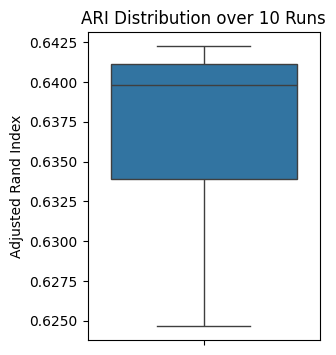

In [12]:
import seaborn as sns
plt.figure(figsize=(3,4))
sns.boxplot(y=aris)
plt.ylabel("Adjusted Rand Index")
plt.title(f"ARI Distribution over {reps} Runs")
plt.show()